### Observations:

It's very important to have some base models to understand how the models are doing.
We will test LightGBM and LSTM against a base model that predicts the next value being the previous one.
PS: Due to the similar nature of the regions, we will be testing only one of them.

In [1]:
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error as RMSE
from src.help_func import preprocess_data, add_weatherFeature

pd.set_option('display.max_columns', None)

In [2]:
# load
path = './datathon-code/data'
ercot_hourly = pd.read_csv(path+'/ercot_hourly_load.csv')
weather_history = pd.read_csv(path+'/weather_history.csv')
weather_forecast = pd.read_csv(path+'/weather_forecast.csv')
ercot_hourly.fillna(method='backfill',inplace=True)

# preprocess
preprocess_data(ercot_hourly, weather_history)

In [3]:
# Train data
train = ercot_hourly.loc['2008':'2021'][['Coast']].fillna(method='backfill')

In [4]:
train.head()

,Coast
Hour_Ending,
2008-01-01 00:00:00,9146.081147
2008-01-01 01:00:00,9437.332603
2008-01-01 02:00:00,9097.955938
2008-01-01 03:00:00,8705.697568
2008-01-01 04:00:00,8463.593994


## 1 Lag Model

<AxesSubplot:xlabel='Hour_Ending'>

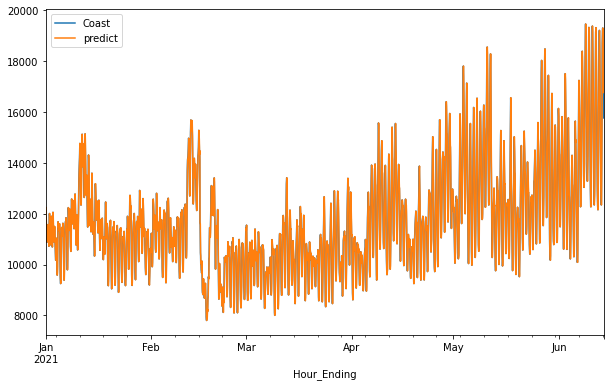

In [9]:
# 1 log forecast
log_forecast = train.shift(1)

# dataframe with real and predict values
predict = train.loc[log_forecast.index]
predict['predict'] = log_forecast.values

# plot predictions 2021
predict['2021':].plot(figsize=(10,6))

/home/joaohenrique/anaconda3/envs/wids/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


<AxesSubplot:xlabel='Hour_Ending'>

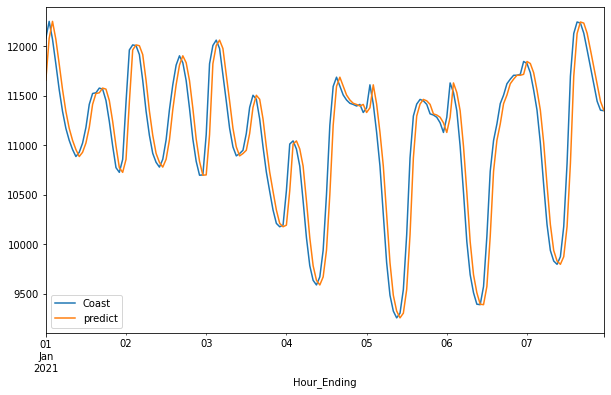

In [10]:
# plot first week for the year - for better visualization
predict['2021'].iloc[:168].plot(figsize=(10,6))

In [11]:
# rmse
predict_2021 = predict['2021':]
log_rmse = round(RMSE(predict_2021.Coast, predict_2021.predict, squared=False))
print(f'1 Log RMSE: {log_rmse}')

1 Log RMSE: 379


## LightGBM

In [32]:
# coast hourly load 
coast_data = ercot_hourly[['Coast']].tz_localize(tz=None).copy()

# add weather features
coast_data['tempC'] = add_weatherFeature('Coast','tempC', weather_history)
coast_data['winddirDegree'] = add_weatherFeature('Coast','winddirDegree', weather_history)

coast_data.dropna(inplace=True)

In [38]:
# adapt dataset for the model
coast_data['hour'] = coast_data.index.hour
coast_data['month'] = coast_data.index.month
coast_data['year'] = coast_data.index.year
coast_data['dayofyear'] = coast_data.index.dayofyear
coast_data['week'] = coast_data.index.isocalendar().week
coast_data['week'] = coast_data['week'].astype(int)

In [39]:
# make basic features
coast_data['last_hour'] = coast_data.Coast.shift()
coast_data['last_hour_diff'] = coast_data.Coast.shift().diff()
coast_data.dropna(inplace=True)

In [40]:
coast_data.head()

,Coast,tempC,winddirDegree,hour,month,year,dayofyear,week,last_hour,last_hour_diff
Hour_Ending,,,,,,,,,,
2008-07-01 04:00:00,12386.530845,23.0,27.0,4,7,2008,183,27,13372.853879,-445.342519
2008-07-01 05:00:00,11382.287900,23.0,27.0,5,7,2008,183,27,12386.530845,-986.323034
2008-07-01 06:00:00,10233.975699,23.0,27.0,6,7,2008,183,27,11382.287900,-1004.242945
2008-07-01 07:00:00,9656.662104,28.0,54.0,7,7,2008,183,27,10233.975699,-1148.312201
2008-07-01 08:00:00,9253.200129,28.0,54.0,8,7,2008,183,27,9656.662104,-577.313596


In [42]:
train = coast_data.loc['2008':'2020'].reset_index(drop=True)
test = coast_data.loc['2021':].reset_index(drop=True)

In [44]:
# lightGBM parameters - Only n_estimators
params = {
    'boosting_type':'gbdt',
    'n_estimators':1000,
    'force_col_wise':True,
    'random_state':42,
    'silent':True
         }
# data split
X_train, y_train = train.drop(['Coast'], axis=1), train['Coast']
X_test, y_test = test.drop(['Coast'], axis=1), test['Coast']

# train model
model = LGBMRegressor(**params, verbose=0)
model.fit(X_train, np.log1p(y_train))

# test forecast
predictions = np.expm1(model.predict(X_test))

# RMSE
gbm_rmse = round(RMSE(y_test, predictions, squared=False))
print(f'LigthGBM RMSE: {gbm_rmse}')

LigthGBM RMSE: 129


### Observations:

The LightGBM model without much effort managed to outperform the base model.

## LSTM

In [6]:
import tensorflow as tf
import functools
from sklearn.preprocessing import StandardScaler

In [8]:
train = ercot_hourly.loc['2008':'2020'][['Coast']].fillna(method='backfill')
test = ercot_hourly.loc['2021':][['Coast']].fillna(method='backfill')

scaler = StandardScaler()
scaler.fit(train['Coast'].values.reshape(-1,1))

train_scaled = scaler.transform(train['Coast'].values.reshape(-1,1))
test_scaled = scaler.transform(test['Coast'].values.reshape(-1,1))

In [9]:
# transform data into batches and windows
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
# make predictions
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
import os
import warnings
warnings.filterwarnings('ignore')

def LSTM(train,window_size = 30,batch_size=64,epochs=100):
    
    # save and load model in path
    checkpoint_path = 'lstm_models_checkpoints'
    checkpoint_dir = os.path.dirname(checkpoint_path)

    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    shuffle_buffer_size = train.shape[0]

    train_set = windowed_dataset(train.reshape(-1), window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

    model = tf.keras.models.Sequential([
      
        tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                          padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=.2)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True,dropout=.2)),
      tf.keras.layers.Dense(1)
    ])
     #Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'/model_baseline.h5',
                                                 save_weights_only=False,
                                                 verbose=1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=[tf.metrics.RootMeanSquaredError(name='rmse')])
    with tf.device('/GPU:0'):
        try:
            model = tf.keras.models.load_model(checkpoint_path+'/model_baseline.h5')
            history = model.fit(train_set, epochs=epochs, callbacks=[cp_callback])
        except:
            print('Not able to load pre-trained model. Training new one...')
            history = model.fit(train_set, epochs=epochs, callbacks=[cp_callback])
    return(history,model)

In [19]:
window_size = 48
hist,model = LSTM(train_scaled,window_size = window_size,batch_size=512,epochs=20)

Epoch 1/20
223/223 [==============================] - 68s 219ms/step - loss: 0.0064 - rmse: 0.1136

Epoch 00001: saving model to lstm_models_checkpoints/model_baseline.h5
Epoch 2/20
223/223 [==============================] - 66s 234ms/step - loss: 6.5244e-04 - rmse: 0.0361

Epoch 00002: saving model to lstm_models_checkpoints/model_baseline.h5
Epoch 3/20
223/223 [==============================] - 65s 212ms/step - loss: 5.3269e-04 - rmse: 0.0326

Epoch 00003: saving model to lstm_models_checkpoints/model_baseline.h5
Epoch 4/20
223/223 [==============================] - 75s 242ms/step - loss: 4.6585e-04 - rmse: 0.0305

Epoch 00004: saving model to lstm_models_checkpoints/model_baseline.h5
Epoch 5/20
223/223 [==============================] - 68s 234ms/step - loss: 4.1465e-04 - rmse: 0.0288

Epoch 00005: saving model to lstm_models_checkpoints/model_baseline.h5
Epoch 6/20
223/223 [==============================] - 67s 225ms/step - loss: 3.8062e-04 - rmse: 0.0276

Epoch 00006: saving model

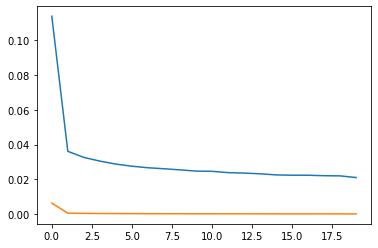

In [20]:
rmse = hist.history['rmse']
loss = hist.history['loss']
plt.plot(rmse)
plt.plot(loss)

In [41]:
# load LSTM Model
checkpoint_path = 'lstm_models_checkpoints'
model = tf.keras.models.load_model(checkpoint_path+'/model_baseline.h5')

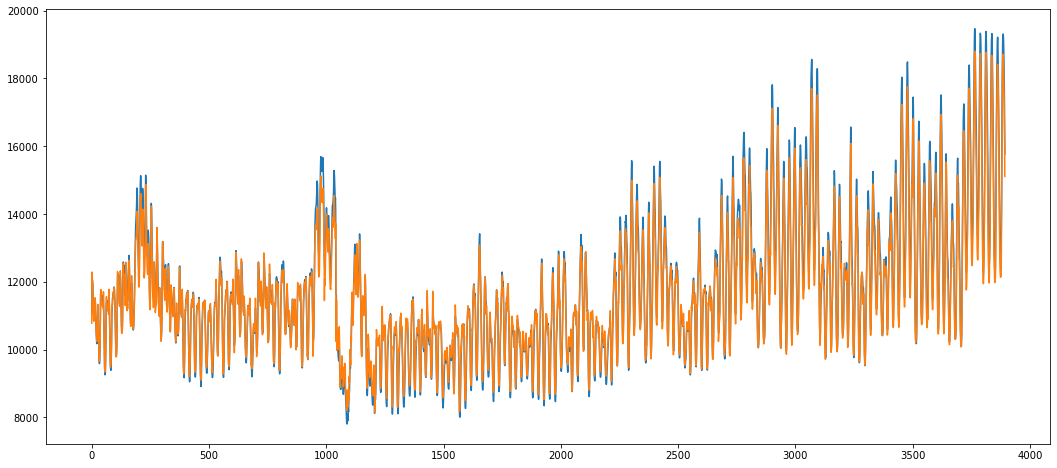

In [42]:
rev_valid_pred = scaler.inverse_transform(model_forecast(model, test_scaled, window_size=window_size))
pred = rev_valid_pred[:-1,-1,0]
plt.figure(figsize=(18,8))
plt.plot(test[window_size:].values)
plt.plot(pred)
plt.show()

In [43]:
lstm_rmse = RMSE(test[window_size:].values,pred, squared=False)
print(f'LSTM RMSE: {lstm_rmse}')

LSTM RMSE: 338.56333731436746


### Observations:
LSTM achieved a better result than the baseline model but it needs to show better results to be used.